In [ ]:
!pip install pandas
!pip install simanneal
!pip install lxml
!pip install networkx
!pip install plotly
!pip install -U kaleido
!pip install html5lib
!pip install jupyter-black jupyter

In [2]:
import pandas as pd
from itertools import compress
import random
import numpy as np
import networkx as nx 
import plotly.express as px
from IPython.display import Image
import plotly.graph_objects as go
import time

# Utils

In [46]:
state_codes = {
    "alabama": "AL",
    "alaska": "AK",
    "arizona": "AZ",
    "arkansas": "AR",
    "california": "CA",
    "colorado": "CO",
    "connecticut": "CT",
    "delaware": "DE",
    "florida": "FL",
    "georgia": "GA",
    "hawaii": "HI",
    "idaho": "ID",
    "illinois": "IL",
    "indiana": "IN",
    "iowa": "IA",
    "kansas": "KS",
    "kentucky": "KY",
    "louisiana": "LA",
    "maine": "ME",
    "maryland": "MD",
    "massachusetts": "MA",
    "michigan": "MI",
    "minnesota": "MN",
    "mississippi": "MS",
    "missouri": "MO",
    "montana": "MT",
    "nebraska": "NE",
    "nevada": "NV",
    "newhampshire": "NH",
    "newjersey": "NJ",
    "newmexico": "NM",
    "newyork": "NY",
    "northcarolina": "NC",
    "northdakota": "ND",
    "ohio": "OH",
    "oklahoma": "OK",
    "oregon": "OR",
    "pennsylvania": "PA",
    "rhodeisland": "RI",
    "southcarolina": "SC",
    "southdakota": "SD",
    "tennessee": "TN",
    "texas": "TX",
    "utah": "UT",
    "vermont": "VT",
    "virginia": "VA",
    "washington": "WA",
    "westvirginia": "WV",
    "wisconsin": "WI",
    "wyoming": "WY",
}

def eval_states(df, states):
    """
    Evaluates the score of a subset of states
    """
    return df.loc[df["state"].isin(states)]["score"].sum()


def create_grid(n):
    """
    Create a square grid of size nxn
    """
    return [["" for _ in range(n)] for _ in range(n)]


def generate_inbound_moves(g, r, c):
    """
    Creates a set of moves that are one king's move away from (r,c)
    """
    R = len(g)
    C = len(g[0])
    k_moves = [
        [r - 1, c - 1],
        [r - 1, c],
        [r - 1, c + 1],
        [r, c - 1],
        [r, c + 1],
        [r + 1, c - 1],
        [r + 1, c],
        [r + 1, c + 1],
    ]
    f_k_moves = list(
        map(lambda x: ((x[0] < R) & (x[0] >= 0)) & ((x[1] < C) & (x[1] >= 0)), k_moves)
    )
    mv = list(compress(k_moves, f_k_moves))
    return mv


def find_state(g, positions, word, edits, found_word, idx):
    """
    Performs a depth first search to find whether a state has been embedded into a graph within 1 edit
    """
    if (len(word) == len(found_word)) and (edits <= 1):
        return True

    if idx >= len(word):
        return False

    if edits >= 2:
        return False

    i = positions[0]
    j = positions[1]
    if found_word == "":
        if g[i][j] != word[0]:
            edits += 1
        found_word = g[i][j]
        idx = 1

    mvs = generate_inbound_moves(g, i, j)
    for position in mvs:
        r = position[0]
        c = position[1]
        if (r >= 0) and (c >= 0) and (r < len(g)) and (c < len(g[0])):
            tmp_edits = edits
            if word[idx] != g[position[0]][position[1]]:
                    tmp_edits = edits + 1
            tmp_word = found_word + g[position[0]][position[1]]
            tmp_idx = idx + 1
            res = find_state(g, position, word, tmp_edits, tmp_word, tmp_idx)
            if res:
                return res
            tmp_word = found_word
            tmp_idx = idx
            tmp_edits = edits
    return False


def go_through_positions(g, word):
    """
    Iterates through every starting position and performs a depth first search
    """
    for r in range(len(g)):
        for c in range(len(g[0])):
            if find_state(g, [r, c], word, 0, "", 0):
                return True
    else:
        return False


def determine_states(df, s):
    """
    Iterates through every state to which state has been embedded
    """
    found = []
    states = df["state"].tolist()
    for state in states:
        if go_through_positions(s, state):
            found.append(state)
    return found


def find_state_path(g, positions, word, edits, found_word, path, idx):
    """
    Performs a depth first search to find the path taken through the matrix
    """
    if (len(word) == len(found_word)) and (edits <= 1):
        return path

    if idx >= len(word):
        return []

    if edits >= 2:
        return []

    i = positions[0]
    j = positions[1]
    if found_word == "":
        if g[i][j] != word[0]:
            edits += 1
        found_word = g[i][j]
        # print(positions)
        path.extend([positions])
        idx = 1

    mvs = generate_inbound_moves(g, i, j)
    for position in mvs:
        r = position[0]
        c = position[1]

        if (r >= 0) and (c >= 0) and (r < len(g)) and (c < len(g[0])):
            tmp_edits = edits
            if word[idx] != g[position[0]][position[1]]:
                tmp_edits = edits + 1
            tmp_word = found_word + g[position[0]][position[1]]
            tmp_idx = idx + 1
            path.extend([position])
            res = find_state_path(g, position, word, tmp_edits, tmp_word, path, tmp_idx)
            if res:
                return res
            tmp_word = found_word
            tmp_idx = idx
            tmp_edits = edits
            path.pop()
    return []


def go_through_positions_to_find_path(g, word):
    for r in range(len(g)):
        for c in range(len(g[0])):
            res = find_state_path(g, [r, c], word, 0, "", [], 0)
            if res:
                return res
    else:
        return False

def determine_coast_to_coast(s):
    '''
    Determines if a set of states contains a path from the Pacific Coast to the Atlantic Coast
    '''
    filtered_dict = {k:v for k,v in usa_graph.items() if k in s}
    
    for k,v in filtered_dict.items():
        f = []
        for s in v:
            if s in s:
                f.append(s)
        filtered_dict[k] = f

    G = nx.Graph(filtered_dict)
    pacific_states = [
        'washington',
        'oregon',
        'california'
    ]
    
    atlantic_coast_states = [
        'maine', 'newhampshire', 'massachusetts', 'rhodeisland', 'connecticut',
        'newyork', 'newjersey', 'pennsylvania', 'delaware', 'maryland',
        'virginia', 'northcarolina', 'southcarolina', 'georgia', 'florida'
    ]

    for ps in pacific_states:
        for at_s in atlantic_coast_states:
            try: 
                return True if nx.shortest_path(G, ps, at_s) else False
            except:
                pass
    return False

# Scoring and Evaluation

In [47]:
def read_us_population_table():
    with open("us_population_by_state.html") as f:
        eval_df = pd.read_html(f)[0]
    eval_df = eval_df[["State", "Population (2020)[86]"]].rename(
        columns={"State": "state", "Population (2020)[86]": "score"}
    )
    eval_df["state"] = eval_df["state"].str.lower().str.replace(" ", "")

    eval_df = eval_df.loc[
        (eval_df["state"] != "districtofcolumbia")
        & (eval_df["state"] != "unitedstates")
    ]
    return eval_df

In [48]:
eval_df = read_us_population_table()

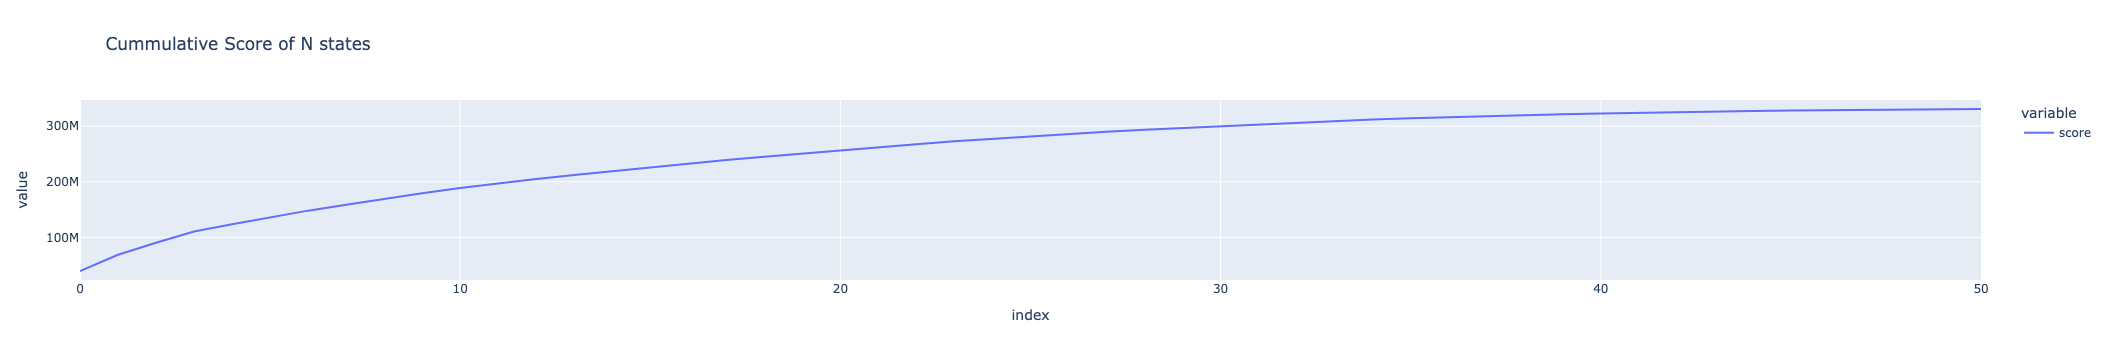

In [49]:
px.line(eval_df["score"].cumsum(), title="Cummulative Score of N states")

# Anneal

In [50]:
from simanneal import Annealer


class AlteredStatesProblem(Annealer):
    def __init__(self, state, data):
        super(AlteredStatesProblem, self).__init__(state)  # important!
        self.data = data
        self.TOTAL = self.data['score'].sum()

    def move_add_letter(self):
        """
        Generates a random letter and places it into a random position
        """
        initial_energy = self.energy()
        random_r = np.random.randint(0, len(self.state))
        random_c = np.random.randint(0, len(self.state[0]))
        letter = chr(np.random.randint(ord("a"), ord("a") + 26 - 1))
        self.state[random_r][random_c] = letter
        return self.energy() - initial_energy

    def move_swap_letter(self):
        """
        Swaps two letters within the matrix
        """
        initial_energy = self.energy()
        random_r_a = np.random.randint(0, len(self.state))
        random_c_a = np.random.randint(0, len(self.state[0]))

        random_r_b = np.random.randint(0, len(self.state))
        random_c_b = np.random.randint(0, len(self.state[0]))

        tmp = self.state[random_r_a][random_c_a]
        self.state[random_r_a][random_c_a] = self.state[random_r_b][random_c_b]
        self.state[random_r_b][random_c_b] = tmp
        return self.energy() - initial_energy

    def move(self):
        """
        Make the state changes

        1. Add New State
        2. Find new orientation of latest placed state
        """
        initial_energy = self.energy()
        states_to_choose = []
        direction = random.random()
        if direction > 0.5:
            return self.move_add_letter()
        else:
            return self.move_swap_letter()

    def energy(self):
        MAX_E = self.TOTAL
        if self.state:
            f = determine_states(self.data, self.state)
            T = eval_states(self.data, f)
        return MAX_E - T

In [51]:
test = create_grid(5)
tsp = AlteredStatesProblem(test, eval_df)
state, e = tsp.anneal() 

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000   96750175.00     6.40%     0.00%     0:24:09     0:00:00

In [52]:
eval_df['score'].sum() - e 

np.int64(234009561)

In [53]:
found_states = determine_states(eval_df, state)
len(determine_states(eval_df, state))

27

## Results

In [59]:
state = [['d', 'g', 'h', 't', 'u'],
 ['a', 'i', 'r', 'c', 's'],
 ['s', 'n', 'o', 'a', 'i'],
 ['e', 'r', 'm', 'l', 'n'],
 ['t', 'w', 'k', 'o', 'd']]

In [61]:
found_states = determine_states(eval_df, state)
len(determine_states(eval_df, state))

29

In [63]:
eval_states(eval_df, determine_states(eval_df, state))

np.int64(250208980)

## Constraints

In [64]:
usa_graph = {
    'washington': ['idaho', 'oregon'],
    'oregon': ['washington', 'idaho', 'california', 'nevada'],
    'idaho': ['washington', 'oregon', 'montana', 'wyoming', 'utah', 'nevada'],
    'montana': ['idaho', 'northdakota', 'southdakota', 'wyoming'],
    'northdakota': ['montana', 'minnesota', 'southdakota'],
    'minnesota': ['northdakota', 'wisconsin', 'iowa', 'southdakota'],
    'wisconsin': ['minnesota', 'iowa', 'illinois', 'michigan'],
    'michigan': ['wisconsin', 'illinois', 'indiana', 'ohio'],
    'illinois': ['wisconsin', 'indiana', 'kentucky', 'missouri', 'iowa'],
    'indiana': ['illinois', 'michigan', 'ohio', 'kentucky'],
    'ohio': ['michigan', 'indiana', 'kentucky', 'westvirginia', 'pennsylvania'],
    'pennsylvania': ['ohio', 'westvirginia', 'maryland', 'delaware', 'newjersey', 'newyork'],
    'newyork': ['pennsylvania', 'newjersey', 'vermont', 'massachusetts', 'connecticut'],
    'vermont': ['newyork', 'newhampshire'],
    'newhampshire': ['vermont', 'maine'],
    'maine': ['newhampshire'],
    'massachusetts': ['newyork', 'connecticut', 'rhodeisland', 'newhampshire', 'vermont'],
    'connecticut': ['newyork', 'massachusetts', 'rhodeisland'],
    'rhodeisland': ['massachusetts', 'connecticut'],
    'newjersey': ['pennsylvania', 'delaware', 'newyork'],
    'delaware': ['pennsylvania', 'maryland', 'newjersey'],
    'maryland': ['delaware', 'pennsylvania', 'westvirginia', 'virginia'],
    'westvirginia': ['pennsylvania', 'ohio', 'kentucky', 'virginia'],
    'virginia': ['maryland', 'westvirginia', 'kentucky', 'tennessee', 'northcarolina'],
    'kentucky': ['ohio', 'indiana', 'illinois', 'missouri', 'tennessee', 'virginia', 'westvirginia'],
    'tennessee': ['kentucky', 'virginia', 'northcarolina', 'georgia', 'alabama', 'mississippi', 'arkansas', 'missouri'],
    'northcarolina': ['virginia', 'tennessee', 'georgia', 'southcarolina'],
    'southcarolina': ['northcarolina', 'georgia'],
    'georgia': ['northcarolina', 'southcarolina', 'florida', 'alabama', 'tennessee'],
    'florida': ['georgia', 'alabama'],
    'alabama': ['mississippi', 'tennessee', 'georgia', 'florida'],
    'mississippi': ['arkansas', 'louisiana', 'tennessee', 'alabama'],
    'louisiana': ['texas', 'arkansas', 'mississippi'],
    'arkansas': ['missouri', 'tennessee', 'mississippi', 'louisiana', 'texas', 'oklahoma'],
    'missouri': ['iowa', 'illinois', 'kentucky', 'tennessee', 'arkansas', 'oklahoma', 'kansas', 'nebraska'],
    'iowa': ['minnesota', 'wisconsin', 'illinois', 'missouri', 'nebraska', 'southdakota'],
    'nebraska': ['southdakota', 'iowa', 'missouri', 'kansas', 'colorado', 'wyoming'],
    'kansas': ['nebraska', 'missouri', 'oklahoma', 'colorado'],
    'oklahoma': ['kansas', 'missouri', 'arkansas', 'texas', 'newmexico', 'colorado'],
    'texas': ['oklahoma', 'arkansas', 'louisiana', 'newmexico'],
    'newmexico': ['colorado', 'oklahoma', 'texas', 'arizona', 'utah'],
    'colorado': ['wyoming', 'nebraska', 'kansas', 'oklahoma', 'newmexico', 'utah'],
    'utah': ['idaho', 'wyoming', 'colorado', 'arizona', 'nevada'],
    'nevada': ['idaho', 'utah', 'arizona', 'california'],
    'arizona': ['utah', 'newmexico', 'texas', 'california', 'nevada'],
    'california': ['oregon', 'nevada', 'arizona']
}


In [73]:
class ConstrainedAlteredStatesProblem(AlteredStatesProblem):
    def __init__(self, state, data):
        super(ConstrainedAlteredStatesProblem, self).__init__(state, data)

    def energy(self):
      MAX_E = self.TOTAL
      if self.state:
        f = determine_states(self.data, self.state)

        if 'california' in f:
          T = 0
            
        else:
          T = eval_states(self.data, f)
          if (determine_coast_to_coast(f)):
            # print(f)
            T = T * 1.10
          else:
            T = T * 0.60
      return (MAX_E - T)


In [74]:
test = create_grid(5)
tsp = ConstrainedAlteredStatesProblem(test, eval_df)
tsp.copy_strategy = "deepcopy"
state, e = tsp.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000  124478084.60     8.20%     0.00%     0:22:43     0:00:00

In [77]:
state

[['d', 'n', 'e', 't', 'e'],
 ['a', 'w', 'a', 'm', 'c'],
 ['l', 'r', 's', 'h', 'o'],
 ['f', 'o', 'k', 'i', 'r'],
 ['c', 'g', 'n', 'a', 'g']]

## Results 

In [78]:
constrained_solution = [['s', 'w', 'y', 'e', 'r'],
 ['t', 'e', 'i', 'o', 's'],
 ['l', 'd', 'n', 's', 'm'],
 ['i', 'o', 'a', 'i', 'a'],
 ['u', 'r', 'g', 'h', 'l']]

# Evidence of Success

* Evidence of C2C
* Evidence of Existance
    * Paths with highlights for each state
* Evidence of Score


## Evidence of C2C

In [80]:
test = constrained_solution

codes = list(map(lambda x: state_codes[x], determine_states(eval_df, test)))

In [81]:
import plotly.io as pio
pio.renderers.default = 'iframe'

fig = px.choropleth(locations=codes, 
                    locationmode="USA-states",
                    color=[1]*len(codes),
                    scope="usa",
                    title = 'states selected from simulated annealing'
                   )
fig.show()

## Evidence of Existence

In [85]:
state_in_solutions = determine_states(eval_df, constrained_solution)
for found_state in state_in_solutions:
    res = go_through_positions_to_find_path(constrained_solution, found_state)
    print(res)
    grid = np.zeros([5,5])
    for r in res:
        grid[r[0],r[1]] = 1 
    figHeatmap = go.Figure(
                       data=go.Heatmap(
                                       z=grid, 
                                       text=constrained_solution, 
                                       texttemplate="%{text}", 
                                       textfont={"size":20}
                                       )
                      )
    figHeatmap.update_layout(
            title=found_state+ f'<br><sup>{" -> ".join([f"{r[0]},{r[1]}" for r in res])}</sup>',
            yaxis=dict(visible=True,autorange='reversed')
        )

    # img_bytes = figHeatmap.to_image(format="png", width=600, height=350, scale=2)
    # Image(img_bytes)
    figHeatmap.show()
    print('='* 15)
    time.sleep(5)

[[1, 0], [1, 1], [2, 1], [3, 2], [2, 3]]


[[1, 0], [2, 0], [3, 1], [4, 1], [3, 0], [2, 1], [3, 2]]


[[2, 2], [1, 1], [0, 1], [0, 2], [1, 3], [0, 4], [0, 3]]


[[3, 0], [2, 0], [1, 1], [1, 2], [2, 2], [1, 3], [1, 2], [2, 3]]


[[1, 3], [0, 2], [1, 2], [1, 3]]


[[4, 2], [3, 2], [3, 1], [4, 1], [4, 2], [3, 3], [3, 2]]


[[2, 4], [3, 3], [3, 2], [4, 3], [3, 3], [4, 2], [3, 2], [2, 2]]


[[2, 2], [1, 1], [0, 1], [0, 2], [0, 3], [0, 4], [1, 4], [0, 3], [0, 2]]


[[2, 0], [3, 0], [4, 1], [4, 2], [3, 3], [2, 2], [3, 3], [3, 2]]


[[3, 2], [4, 1], [3, 0], [2, 0], [3, 1], [2, 2], [3, 2]]


[[1, 2], [2, 2], [2, 1], [1, 2], [1, 1], [2, 2], [3, 2]]


[[2, 4], [3, 3], [2, 3], [2, 2], [3, 1], [4, 0], [4, 1], [3, 0]]


[[0, 1], [1, 2], [2, 3], [1, 2], [1, 3], [2, 2], [2, 3], [1, 2], [2, 2]]


[[2, 0], [3, 1], [2, 0], [3, 1], [4, 1], [3, 2], [2, 1], [3, 1]]


[[3, 4], [4, 4], [3, 4], [2, 3], [3, 4], [2, 4], [3, 4]]


[[2, 0], [3, 1], [2, 1], [1, 2], [2, 3], [3, 3], [3, 2], [2, 2], [3, 2]]


[[1, 3], [0, 4], [0, 3], [0, 2], [1, 3], [2, 2]]


[[4, 0], [3, 1], [3, 2], [4, 3]]


[[1, 2], [1, 3], [2, 2], [3, 2]]


[[2, 2], [1, 1], [2, 1], [3, 2], [2, 1], [3, 2]]


[[3, 2], [4, 1], [3, 1], [3, 2], [2, 2], [2, 3], [3, 2], [2, 3]]


[[2, 1], [3, 2], [2, 2], [2, 3], [3, 2], [2, 3]]


[[1, 2], [2, 1], [3, 2], [2, 1], [3, 1]]


[[0, 1], [1, 1], [0, 0], [1, 0], [2, 0], [3, 0], [4, 1], [4, 2], [3, 3], [2, 2], [3, 3], [3, 2]]


[[2, 1], [3, 2], [3, 3], [2, 2], [1, 1]]


[[2, 4], [1, 3], [2, 2], [2, 1], [3, 2], [2, 2], [3, 2]]


[[3, 4], [4, 4], [3, 4], [2, 3], [2, 2], [3, 2]]


[[0, 1], [0, 2], [1, 3], [2, 4], [3, 3], [2, 2], [1, 1]]


## Evidence of Score

In [86]:
eval_df.loc[eval_df['state'].isin(state_in_solutions)]

,state,score
1,texas,29145505
2,florida,21538187
3,newyork,20201249
5,illinois,12812508
6,ohio,11799448
7,georgia,10711908
9,michigan,10077331
10,newjersey,9288994
11,virginia,8631393
13,arizona,7151502


In [87]:
eval_df.loc[eval_df['state'].isin(state_in_solutions)]['score'].sum()

np.int64(202790841)

# Submission

In [88]:
example_grid = [
    ['t','h','o'],
    ['a','i','n'],
    ['e','s','l'],
]

In [89]:
''.join([''.join(i) for i in example_grid])

'thoainesl'

In [90]:
''.join([''.join(i) for i in test])

'swyerteiosldnsmioaiaurghl'